In [113]:
##Bring in the appropriate packages
import datetime
import time
import pandas as pd
import numpy as np
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import pickle

In [114]:
##Create definition for working with date and time items
def convert_duration(duration_str):
    # Pattern for 'PT#H#M' and 'P#DT#H#M'
    pattern = re.compile(r'P(?:(\d+)D)?T(?:(\d+)H)?(?:(\d+)M)?')

    match = pattern.match(duration_str)
    if match:
        days = int(match.group(1) or 0)
        hours = int(match.group(2) or 0)
        minutes = int(match.group(3) or 0)
        total_minutes = days * 24 * 60 + hours * 60 + minutes
        return total_minutes
    else:
        return None

In [115]:
##Create split function for flights with more than one stop
def split_columns(row, column_name):
    values = row[column_name].split("||")
    return values + [0] * (4 - len(values))

In [116]:
##Create translate functions where the PCA will take place

df = pd.read_csv('Atlanta Prices.csv')

# df.info()
df.drop(['legId'],inplace=True,axis=1)
##Drop LegID as this is not needed in the PCA as it is a unique identifier
df = df.dropna()
##Drop any row with NA. In our analysis there are no seats remaining in columns with NA values
# df.info()
## Convert 'searchDate' and 'flightDate' from object to datetime-type
##df['searchDate'] = pd.to_datetime(df['searchDate'])
##df['flightDate'] = pd.to_datetime(df['flightDate'])
columns_to_process = [
    'segmentsDepartureTimeEpochSeconds',
    'segmentsDepartureTimeRaw',
    'segmentsArrivalTimeEpochSeconds',
    'segmentsArrivalTimeRaw',
    'segmentsArrivalAirportCode',
    'segmentsDepartureAirportCode',
    'segmentsAirlineName',
    'segmentsAirlineCode',
    'segmentsEquipmentDescription',
    'segmentsDurationInSeconds',
    'segmentsDistance',
    'segmentsCabinCode',
]

for column_name in columns_to_process:
    new_columns = df.apply(lambda row: split_columns(row, column_name), axis=1, result_type='expand')
    df[[f'{column_name}_1', f'{column_name}_2', f'{column_name}_3', f'{column_name}_4']] = new_columns


In [117]:
df['totalTravelDuration'] = df['travelDuration'].apply(lambda x: convert_duration(x))
# df.head()
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col, inplace=True, axis=1)

df['weeknum'] = pd.to_datetime(df['segmentsDepartureTimeRaw_1'], format='%Y-%m-%dT%H:%M:%S.%f%z').dt.isocalendar().week

df['hour_of_flight']=df['segmentsDepartureTimeRaw_1'].str.split('T').str[1].str.split('.').str[0]
df['departure_min'] = pd.to_datetime(df['hour_of_flight'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(df['hour_of_flight'], format='%H:%M:%S').dt.minute
df['time_of_departure'] = np.where(df['departure_min'] <= (8 * 60), "Morning", np.where(df['departure_min'] <= (16 * 60), "Mid-Day", "Night"))

df['last_arrival_time']=df['segmentsArrivalTimeRaw'].str[-29:]
df['last_arrival_time']=df['last_arrival_time'].str.split('T').str[1].str.split('.').str[0]
df['last_arrival_time']=pd.to_datetime(df['last_arrival_time'], format='%H:%M:%S').dt.hour * 60 + pd.to_datetime(df['last_arrival_time'], format='%H:%M:%S').dt.minute
df['time_of_arrival'] = np.where(df['last_arrival_time'] <= (8 * 60), "Morning", np.where(df['last_arrival_time'] <= (16 * 60), "Mid-Day", "Night"))


print(df[['segmentsDepartureTimeRaw_1','weeknum','time_of_departure','time_of_arrival']])

          segmentsDepartureTimeRaw_1  weeknum time_of_departure  \
0      2022-04-17T12:57:00.000-04:00       15           Mid-Day   
1      2022-04-17T06:30:00.000-04:00       15           Morning   
2      2022-04-17T11:35:00.000-04:00       15           Mid-Day   
3      2022-04-17T13:59:00.000-04:00       15           Mid-Day   
4      2022-04-17T09:59:00.000-04:00       15           Mid-Day   
...                              ...      ...               ...   
15998  2022-05-05T08:02:00.000-04:00       18           Mid-Day   
15999  2022-05-05T09:00:00.000-04:00       18           Mid-Day   
16000  2022-05-05T22:38:00.000-04:00       18             Night   
16001  2022-05-05T10:00:00.000-04:00       18           Mid-Day   
16002  2022-05-05T16:45:00.000-04:00       18             Night   

      time_of_arrival  
0             Mid-Day  
1             Mid-Day  
2             Mid-Day  
3               Night  
4             Mid-Day  
...               ...  
15998         Mid-Day  
159

In [118]:
columns_to_count = ['segmentsAirlineName_1', 'segmentsAirlineName_2', 'segmentsAirlineName_3', 'segmentsAirlineName_4']
df['no_airlines'] = df[columns_to_count].apply(lambda row: len(set(filter(lambda x: x != 0, row))), axis=1)

In [119]:
columns_to_count = ['segmentsArrivalAirportCode_1', 'segmentsArrivalAirportCode_2', 'segmentsArrivalAirportCode_3', 'segmentsArrivalAirportCode_4']
df['no_layovers'] = df[columns_to_count].apply(lambda row: len(set(filter(lambda x: x != 0, row))), axis=1)
print(df['no_layovers'])

0        1
1        1
2        1
3        1
4        1
        ..
15998    2
15999    2
16000    2
16001    1
16002    1
Name: no_layovers, Length: 14303, dtype: int64


In [120]:
df.columns

Index(['searchDate', 'flightDate', 'destinationAirport', 'fareBasisCode',
       'travelDuration', 'elapsedDays', 'isBasicEconomy', 'isNonStop',
       'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance',
       'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
       'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
       'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
       'segmentsAirlineName', 'segmentsAirlineCode',
       'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
       'segmentsDistance', 'segmentsCabinCode',
       'segmentsDepartureTimeEpochSeconds_1',
       'segmentsDepartureTimeEpochSeconds_2',
       'segmentsDepartureTimeEpochSeconds_3',
       'segmentsDepartureTimeEpochSeconds_4', 'segmentsDepartureTimeRaw_1',
       'segmentsDepartureTimeRaw_2', 'segmentsDepartureTimeRaw_3',
       'segmentsDepartureTimeRaw_4', 'segmentsArrivalTimeEpochSeconds_1',
       'segmentsArrivalTimeEpochSeconds_2',
     

In [121]:
columns_to_keep = ['destinationAirport','isBasicEconomy', 'isNonStop', 'baseFare', 'seatsRemaining', 
                   'totalTravelDistance', 'totalTravelDuration','weeknum', 
                   'time_of_departure', 'time_of_arrival', 'no_airlines', 'no_layovers'
                  ,'segmentsCabinCode_1']

df = df[columns_to_keep]

df.head()

,destinationAirport,isBasicEconomy,isNonStop,baseFare,seatsRemaining,totalTravelDistance,totalTravelDuration,weeknum,time_of_departure,time_of_arrival,no_airlines,no_layovers,segmentsCabinCode_1
0,BOS,False,True,217.67,9.0,947.0,149,15,Mid-Day,Mid-Day,1,1,coach
1,BOS,False,True,217.67,4.0,947.0,150,15,Morning,Mid-Day,1,1,coach
2,BOS,False,True,217.67,9.0,947.0,150,15,Mid-Day,Mid-Day,1,1,coach
3,BOS,False,True,217.67,8.0,947.0,152,15,Mid-Day,Night,1,1,coach
4,BOS,False,True,217.67,9.0,947.0,154,15,Mid-Day,Mid-Day,1,1,coach


In [122]:
df.to_csv('AtlantaPrices_Processed.csv', index=False)

In [129]:
df=pd.read_csv('AtlantaPrices_Processed.csv')

In [130]:
print(df.isna().sum())

destinationAirport     0
isBasicEconomy         0
isNonStop              0
baseFare               0
seatsRemaining         0
totalTravelDistance    0
totalTravelDuration    0
weeknum                0
time_of_departure      0
time_of_arrival        0
no_airlines            0
no_layovers            0
segmentsCabinCode_1    0
dtype: int64


In [140]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA


# Step 1: One-hot encode non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['int', 'float']).columns

one_hot_encoder = OneHotEncoder(sparse=False) #, drop='first')  # 'drop' is set to 'first' to avoid the dummy variable trap
encoded_columns = pd.DataFrame(one_hot_encoder.fit_transform(df[non_numeric_columns]))
encoded_columns.columns = one_hot_encoder.get_feature_names_out(non_numeric_columns)

df_PCA = pd.concat([df.drop(columns=non_numeric_columns), encoded_columns], axis=1)

# Step 2: Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_PCA)

# Step 3: Perform PCA
# You can specify the number of components you want to keep
num_components = 24  # Change this to your desired number of components
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(scaled_data)

# Now, pca_result contains the transformed data after PCA
# You can convert it back to a DataFrame if needed
pca_dataframe = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(num_components)])

# Print the resulting DataFrame
print(pca_dataframe.head())

/Users/maria/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.510904  1.346207 -1.111237 -0.266321  0.345049 -0.502365  0.346044   
1 -2.214743  1.294716 -2.010674  0.675326 -1.345372  0.146349 -0.364235   
2 -2.509008  1.345456 -1.111303 -0.265948  0.344966 -0.502610  0.346149   
3 -2.056213  1.335252  0.939625 -1.113356  0.755003 -0.137005  0.424440   
4 -2.501422  1.342452 -1.111564 -0.264455  0.344636 -0.503591  0.346569   

        PC8       PC9      PC10  ...      PC15      PC16      PC17      PC18  \
0 -1.200936  0.507735  0.109420  ...  0.468660 -0.332489 -1.646605  0.391982   
1  0.232629  0.206521  0.167301  ...  0.619541 -0.425484 -1.047393  0.129720   
2 -1.201049  0.507899  0.109342  ...  0.468689 -0.332562 -1.646556  0.392093   
3 -0.585273  0.247655  0.020650  ...  0.381677 -0.371912 -1.381600  0.230496   
4 -1.201497  0.508553  0.109030  ...  0.468803 -0.332852 -1.646363  0.392536   

       PC19      PC20      PC21      PC22      PC23      PC24  
0 -1

In [138]:
#Perform PCA with automatic determination of components
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Determine the number of components based on a threshold (e.g., 95% variance explained)
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
num_components = sum(cumulative_variance_ratio >= 0.95)

# Apply PCA with the determined number of components
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(scaled_data)

# Now, pca_result contains the transformed data after PCA
pca_dataframe = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(num_components)])

# Print the resulting DataFrame and explained variance
print(pca_dataframe.head())
print(f"Number of components: {num_components}")
print(f"Cumulative explained variance: {cumulative_variance_ratio[num_components - 1]:.2%}")


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.511190  1.344990 -1.109949 -0.273228  0.349912 -0.487875 -0.249720   
1 -2.215150  1.292609 -2.007281  0.681560 -1.340993  0.152659  0.420054   
2 -2.509294  1.344239 -1.110014 -0.272854  0.349829 -0.488118 -0.249825   
3 -2.057068  1.331580  0.943457 -1.111915  0.753803 -0.104940 -0.337121   
4 -2.501709  1.341234 -1.110274 -0.271358  0.349498 -0.489088 -0.250245   

        PC8       PC9      PC10      PC11      PC12  
0  1.314008  0.601167 -0.361034 -1.869004  0.111690  
1 -0.122647  0.221259 -0.319363 -1.938867  0.405344  
2  1.314132  0.601342 -0.360984 -1.868968  0.111687  
3  0.741818  0.341601 -0.250090 -1.849931  0.294531  
4  1.314626  0.602042 -0.360783 -1.868825  0.111679  
Number of components: 12
Cumulative explained variance: 63.92%


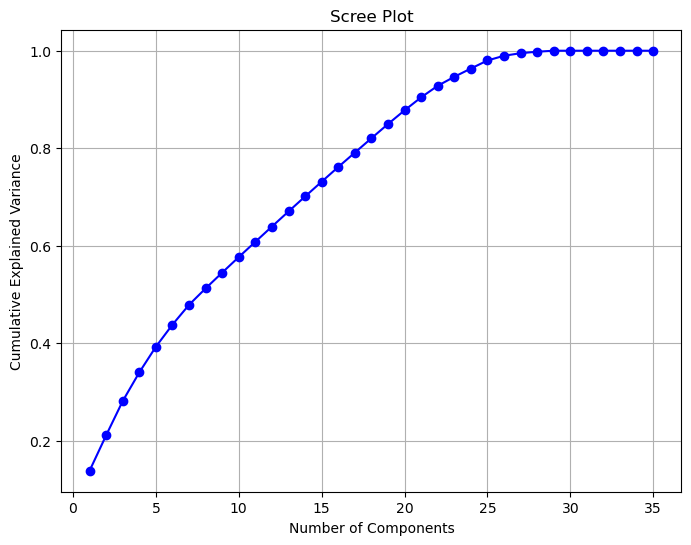

In [139]:
# Scree Plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='b')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [110]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
# IF need to drop the original values
#df.drop(columns=columns_to_process, inplace=True)
#df.drop('travelDuration', axis=1, inplace=True)
df.to_csv('AtlantaPrices_Processed.csv', index=False)
# df.info()
# df.head()

# One-hot encode object columns and convert bool columns to int
# df_encoded = pd.get_dummies(df.select_dtypes(include=['object', 'bool'])).astype(int)
df_encoded = pd.DataFrame()
enc = OneHotEncoder()
for column_name in df.columns:
    try:
        try:
            df[column_name] = df[column_name].astype(np.int64)
        except:
            pass
        if df[column_name].dtype is (int or float or bool or np.int64 or np.float64 or int64):
            df_encoded[column_name] = df[column_name]
            continue
        try:
            df_encoded[column_name] = enc.fit_transform(df[column_name].dropna().values.reshape(-1, 1)).flatten()
        except TypeError as err:
            df_encoded[column_name] = enc.fit_transform(df[column_name].astype('str').dropna().values.reshape(-1, 1)).flatten()
        except Exception as err:
            df_encoded[column_name] = df[column_name]
    except exception as e:
        print(f"Column {column_name} failed with error {e}")


# print("\nOne-Hot Encoded DataFrame:")
# print(df_encoded)
# df_encoded.info()
# df_encoded.head()
df_encoded.to_csv('AtlantaPrices_Encoded.csv', index=False)
# Standardize the data before applying PCA
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_encoded),columns=df_encoded.columns)
df_standardized.to_csv('AtlantaPrices_Standardized.csv', index=False)
# Apply PCA
pca = PCA(svd_solver='auto')
pca_result = pca.fit_transform(df_standardized)

# Display the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio)
##Use Pickle to create a binary hierarchy that can be translated later
pickle.dump(pca, open('pca.pkl', 'wb'))

ValueError: could not convert string to float: 'BOS'

In [9]:
df.head()

,searchDate,flightDate,destinationAirport,fareBasisCode,elapsedDays,isBasicEconomy,isNonStop,baseFare,totalFare,seatsRemaining,...,segmentsDurationInSeconds_3,segmentsDurationInSeconds_4,segmentsDistance_1,segmentsDistance_2,segmentsDistance_3,segmentsDistance_4,segmentsCabinCode_1,segmentsCabinCode_2,segmentsCabinCode_3,segmentsCabinCode_4
0,1650067200000000000,1650153600000000000,BOS,LA0NX0MC,0,0,1,217,248,9,...,0,0,947,0,0,0,coach,0,0,0
1,1650067200000000000,1650153600000000000,BOS,LA0NX0MC,0,0,1,217,248,4,...,0,0,947,0,0,0,coach,0,0,0
2,1650067200000000000,1650153600000000000,BOS,LA0NX0MC,0,0,1,217,248,9,...,0,0,947,0,0,0,coach,0,0,0
3,1650067200000000000,1650153600000000000,BOS,LA0NX0MC,0,0,1,217,248,8,...,0,0,947,0,0,0,coach,0,0,0
4,1650067200000000000,1650153600000000000,BOS,LA0NX0MC,0,0,1,217,248,9,...,0,0,947,0,0,0,coach,0,0,0


In [49]:
import pandas as pd

df = pd.read_csv('AtlantaPrices_Processed.csv')
df['segmentsDepartureTimeRaw_1'] = pd.to_datetime(df['segmentsDepartureTimeRaw_1'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df['weeknum'] = df['segmentsDepartureTimeRaw_1'].dt.isocalendar().week

columns_to_count = ['segmentsAirlineName_1', 'segmentsAirlineName_2', 'segmentsAirlineName_3', 'segmentsAirlineName_4']
df['no_airlines'] = df[columns_to_count].apply(lambda row: len(set(filter(lambda x: x != 0, row)))-1, axis=1)
print(df[['no_airlines', 'segmentsAirlineName_1', 'segmentsAirlineName_2', 'segmentsAirlineName_3', 'segmentsAirlineName_4']])


##for date in (start_date + datetime.timedelta(n) for n in range((end_date - start_date).days + 1)):
  ##  week_num = date.isocalendar()[1]
   ## print(date.strftime('%Y-%m-%d'),"is in week number",week_num)

       no_airlines segmentsAirlineName_1 segmentsAirlineName_2  \
0                1                 Delta                     0   
1                1                 Delta                     0   
2                1                 Delta                     0   
3                1                 Delta                     0   
4                1                 Delta                     0   
...            ...                   ...                   ...   
14298            1     American Airlines     American Airlines   
14299            1                United                United   
14300            1     Frontier Airlines     Frontier Airlines   
14301            1                 Delta                     0   
14302            1                 Delta                     0   

      segmentsAirlineName_3 segmentsAirlineName_4  
0                         0                     0  
1                         0                     0  
2                         0                     0  

In [31]:

import datetime


In [32]:

pd.datetime(df[''])

##pd.datetime(df['segmentsDepartureTimeRaw_1'])

##df['weeknum']=pd.to_datetime().isocalendar()[1]

/var/folders/cf/hcghd3fj49s_s4v1kv5r6z2h0000gq/T/ipykernel_44878/822225857.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime(df['segmentsDepartureTimeRaw_1'])


TypeError: 'Series' object cannot be interpreted as an integer